<a href="https://colab.research.google.com/github/sthalles/fishers-linear-discriminant/blob/master/Fishers_Multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from numpy.linalg import inv,pinv
import numpy as np
from numpy.linalg import eig
import numpy as np
import tensorflow as tf

In [0]:
class DataSet:
  def __init__(self, data, targets, valid_classes=None):
    if valid_classes is None:
      self.valid_classes = np.unique(targets)
    else:
      self.valid_classes = valid_classes
    #print(self.valid_classes)
    self.number_of_classes = len(self.valid_classes)
    self.data = self.to_dict(data, targets)

  def to_dict(self, data, targets):
    data_dict = {}
    for x, y in zip(data, targets):
      if y in self.valid_classes:
        if y not in data_dict:
          data_dict[y] = [x.flatten()]
        else:
          data_dict[y].append(x.flatten())

    for i in self.valid_classes:
      data_dict[i] = np.asarray(data_dict[i])

    return data_dict

  def get_data_by_class(self, class_id):
    if class_id in self.valid_classes:
      return self.data[class_id]
    else:
      raise ("Class not found.")

  def get_data_as_dict(self):
    return self.data

  def get_all_data(self):
    data = []
    labels = []
    for label, class_i_data in self.data.items():
      data.extend(class_i_data)
      labels.extend(class_i_data.shape[0] * [label])
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels

In [0]:
class LDAClassifier:
  
  def __init__(self, projection_dim):
    self.projection_dim = projection_dim
    self.W = None # weights
    self.g_means, self.g_covariance, self.priors = None, None, None

  def fit(self,X):
    means_k = self.__compute_means(X)

    Sks = []
    for class_i, m in means_k.items():
      sub = np.subtract(X[class_i], m)
      Sks.append(np.dot(np.transpose(sub), sub))

    Sks = np.asarray(Sks) # shape = (D,D)

    Sw = np.sum(Sks, axis=0)
    print(Sw.shape)

    Nk = {}
    sum_ = 0
    for class_id, data in X.items():
      Nk[class_id] = data.shape[0]
      sum_ += np.sum(data, axis=0)

    self.N = sum(list(Nk.values()))

    # m is the mean of the total data set
    m = sum_ / self.N

    SB = []
    for class_id, mean_class_i in means_k.items():
      sub_ = mean_class_i - m
      SB.append(np.multiply(Nk[class_id], np.outer(sub_, sub_.T)))
    
    # between class covariance matrix shape = (D,D). D = input vector dimensions
    SB = np.sum(SB, axis=0)  # sum of K (# of classes) matrices

    matrix = np.dot(pinv(Sw), SB)
    # find eigen values and eigen-vectors pairs for np.dot(pinv(SW),SB)
    eigen_values, eigen_vectors = eig(matrix)
    print("eigen_values:", eigen_values.shape)
    print("eigen_vectors:", eigen_vectors.shape)

    eiglist = [(eigen_values[i], eigen_vectors[:, i]) for i in range(len(eigen_values))]

    # sort the eigvals in decreasing order
    eiglist = sorted(eiglist, key=lambda x: x[0], reverse=True)

    # take the first num_dims eigvectors
    self.W = np.array([eiglist[i][1] for i in range(self.projection_dim)])
    self.W = np.asarray(self.W).T

    # get parameter of the Gaussian distribution
    self.g_means, self.g_covariance, self.priors = self.gaussian(X)

  # Returns the parameters of the Gaussian distributions
  def gaussian(self, X):
    means = {}
    covariance = {}
    priors = {}  # p(Ck)
    for class_id, values in X.items():
      proj = np.dot(values, self.W)
      means[class_id] = np.mean(proj, axis=0)
      covariance[class_id] = np.cov(proj, rowvar=False)
      priors[class_id] = values.shape[0] / self.N
    return means, covariance, priors
  
  # model a multi-variate Gaussian distribution for each class’ likelihood distribution P(x|Ck)
  def gaussian_distribution(self, x, u, cov):
    scalar = (1. / ((2 * np.pi) ** (x.shape[0] / 2.))) * (1 / np.sqrt(np.linalg.det(cov)))
    x_sub_u = np.subtract(x, u)
    return scalar * np.exp(-np.dot(np.dot(x_sub_u, inv(cov)), x_sub_u.T) / 2.)

  def score(self,X,y):
    proj = self.project(X)
    gaussian_likelihoods = []
    classes = sorted(list(self.g_means.keys()))
    for x in proj:
      row = []
      for c in classes:  # number of classes
        res = self.priors[c] * self.gaussian_distribution(x, self.g_means[c], self.g_covariance[c])  # Compute the posterios P(Ck|x) prob of a class k given a point x
        row.append(res)

      gaussian_likelihoods.append(row)

    gaussian_likelihoods = np.asarray(gaussian_likelihoods)
    
    # assign x to the class with the largest posterior probability
    predictions = np.argmax(gaussian_likelihoods, axis=1)
    return np.sum(predictions == y) / len(y), predictions, proj

  def project(self,X):
    return np.dot(X, self.W)

  def __compute_means(self, X):
    # Compute the means for each class k=1,2,3...K
    # If the dataset has K classes, then, self.means_k.shape = [# of records, K]
    means_k = {}
    for class_i, input_vectors in X.items():
      means_k[class_i] = np.mean(input_vectors, axis=0)
    return means_k

In [70]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

train_dataset = DataSet(x_train, y_train)
inputs, targets = train_dataset.get_all_data()

print(inputs.shape,targets.shape)

clf = LDAClassifier(projection_dim=2)
clf.fit(train_dataset.get_data_as_dict())

acc = clf.score(inputs,targets)[0]
print("Train acc:", acc)

(60000, 784) (60000,)
Sks.shape: (10, 784, 784)
(784, 784)
Total # of records: 60000
eigen_values: (784,)
eigen_vectors: (784, 784)
(784, 2)
Train acc: 0.57645
Test acc: 0.565


Test acc: 0.565


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


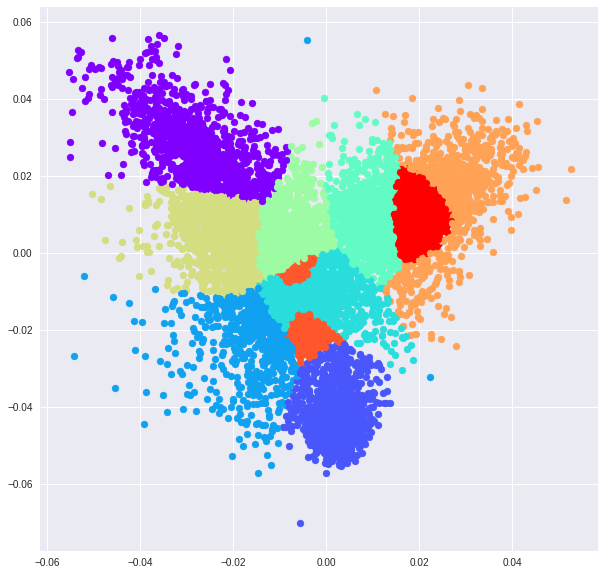

In [80]:
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm

test_dataset = DataSet(x_test, y_test)
inputs, targets = test_dataset.get_all_data()

acc, predictions, proj = clf.score(inputs,targets)
print("Test acc:", acc)
inputs, targets = test_dataset.get_all_data()

classes = list(np.unique(y_test))
colors = cm.rainbow(np.linspace(0, 1, len(classes)))
plotlabels = {classes[c] : colors[c] for c in range(len(classes))}

plt.figure(figsize=(10,10))
for point,pred in zip(proj,predictions):
  plt.scatter(point[0],point[1],color=plotlabels[pred])
plt.show()

/usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/axes3d.py:1714: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[which_pt] = np.array(ps2[i1]) - np.array(ps2[i2])
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/axes3d.py:1715: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[which_pt] = np.array(ps2[i2]) - np.array(ps2[i3])
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


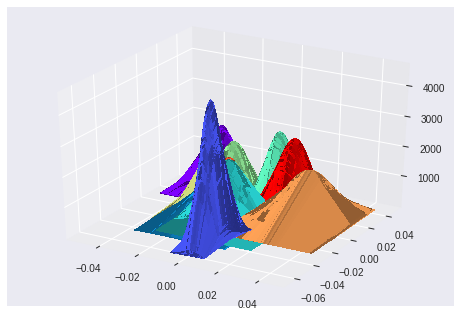

In [77]:
  from mpl_toolkits.mplot3d import Axes3D
  
  classes = np.unique(y)
  colors = cm.rainbow(np.linspace(0, 1, len(classes)))
  plotlabels = {classes[c] : colors[c] for c in range(len(classes))}

  fig = plt.figure()
  ax3D = fig.add_subplot(111, projection='3d')
  for c in classes:
      data = np.random.multivariate_normal(clf.g_means[c], 
                                           clf.g_covariance[c], size=100)

      X, Y = np.meshgrid(data.T[0], data.T[1])
      
      zs = np.array([clf.gaussian_distribution(np.array(point),clf.g_means[c],clf.g_covariance[c]) for point in zip(np.ravel(X), np.ravel(Y))])
      Z = zs.reshape(X.shape)
      surf = ax3D.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                                 color=plotlabels[c], linewidth=0, 
                                 antialiased=False)
  plt.show()